<a href="https://colab.research.google.com/github/naoya1110/ai_robotics_lab_2022_hands_on/blob/main/Week06_Practical_Techniques_for_Training_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCKU-NITKC AI Robotics Lab - Week 06

## Introduction

In this notebook we are going to learn about practical techniques for training convolutional neural network (CNN) models such as


*   Data Standardization
*   Data Augmentation
*   Dropout Layer
*   L1, L2 Regularization



 As we saw last week, deep neural network models can easily fall into the overfit state. So we always have to be careful about the models not to be overfitted during the training. Thanks to the intensive researches in this field, a lot of practical techniques that are effective for avoiding overfitting have already been discovered. In this notebook we are going to implement some of those techniques and see how they work.

### GPU

We will need a GPU to train CNN models, so please make sure your runtime type is GPU (cuda).

In [ ]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

### General Packages

Let's import some of general Python packages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

## Data Preparation

### CIFAR10

We will use CIFAR10 dataset again.

In [ ]:
from torchvision.datasets import CIFAR10

train_dataset = CIFAR10(root="cifar10", train=True, download=True)
test_dataset = CIFAR10(root="cifar10", train=False, download=True)

classnames = {0:"plane", 
              1:"car", 
              2:"bird", 
              3:"cat", 
              4:"deer",
              5:"dog", 
              6:"frog", 
              7:"horse",
              8:"ship",
              9:"truck"}

### Data Standardization (aka. z-score normalization)

Data rescaling is often employed as a preprocessing step of data preparations. One of the data rescaling methods is standardization (aka. z-score normalization). A raw data $x_i$ will be converted to a standardized data $z_i$ by the equation below, where $\mu$ and $\sigma$ are mean and standard deviation of the raw dataset, respectively.

$\displaystyle z_i=\dfrac{x_i-\mu}{\sigma}$ 

By standardization, the mean and the standard deviation of the new dataset will be 0 and 1 respectively.

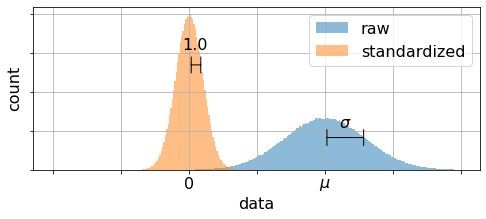

In order to standardize CIFAR10 image data, we need to know the means $\mu$ and the standard deviations $\sigma$ of red, green, blue pixels in the raw dataset. To do this, first we collect all red, green and blue pixels data in numpy arrays.

In [ ]:
red_pixels = []
green_pixels = []
blue_pixels = []

for image, label in tqdm(train_dataset):
    image = np.array(image)/255.        # normalize data from 0-255 to 0.0-1.0
    image = image.astype("float32")

    red_pixels.append(image[:,:,0])     # take only red pixels
    green_pixels.append(image[:,:,1])   # take only green pixels
    blue_pixels.append(image[:,:,2])    # take only blue pixels

# convert data to 1D array
red_pixels = np.array(red_pixels).flatten()
green_pixels = np.array(green_pixels).flatten()
blue_pixels = np.array(blue_pixels).flatten()

print("number of red pixels", red_pixels.shape)
print("number of green pixels", green_pixels.shape)
print("number of blue pixels", blue_pixels.shape)

Let's take a look at their distributions.

In [ ]:
plt.figure(figsize=(5, 5))

bins = np.arange(0, 1.01, 0.05)

plt.subplot(3, 1, 1)
plt.hist(red_pixels, bins=bins, color="r")

plt.subplot(3, 1, 2)
plt.hist(green_pixels, bins=bins, color="g")

plt.subplot(3, 1, 3)
plt.hist(blue_pixels, bins=bins, color="b")

Now we can determine means of red, green and blue pixels.

In [ ]:
means = (red_pixels.mean(), green_pixels.mean(), blue_pixels.mean())
means

Also standard deviations of red, green and blue pixels.

In [ ]:
stds = (red_pixels.std(), green_pixels.std(), blue_pixels.std())
stds

Then we can standardize the raw dataset by using `means` and `stds` data, and see how the standardized dataset distributes.

In [ ]:
# standardization
red_pixels_z = (red_pixels-means[0])/stds[0]
green_pixels_z = (green_pixels-means[1])/stds[1]
blue_pixels_z = (blue_pixels-means[2])/stds[2]

# visualize distributions
plt.figure(figsize=(5, 5))

bins=np.arange(-3,3.1,0.2)

plt.subplot(3, 1, 1)
plt.hist(red_pixels_z, bins=bins, color="r")

plt.subplot(3, 1, 2)
plt.hist(green_pixels_z, bins=bins, color="g")

plt.subplot(3, 1, 3)
plt.hist(blue_pixels_z, bins=bins, color="b")

We will use the `means` and `stds` data later when we reload the CIFAR10 dataset with `torch.tensor` format.

### Data Augmentation

Another technique often used as a preprocessing is data augmentation. Data augmentation is a very powerful technique for avoiding the model being overfitted especially when number of training data is limited. In each training epoch, slightly modified copies of the images are generated from the original images. This is effective to prevent the model from just remembering training data because the model will never see exactly same data again. The data augmention can be implemented easily by using `torchvision.transforms` module.

Here we take one image from training data and let's see how this image can be augmented.

In [ ]:
image, label = train_dataset[1]
plt.imshow(image)
plt.title(classnames[label])

x = image

#### Random Horizontal Flip



In [ ]:
from torchvision import transforms
transform = transforms.RandomHorizontalFlip(p=0.5)

def show_transformed_images(transform, x):
    plt.figure(figsize=(12, 3))
    for i in range(5):
        output_image = transform(x)
        plt.subplot(1, 5, i+1)
        plt.imshow(output_image)

show_transformed_images(transform, x)

#### Random Vertical Flip

In [ ]:
transform = transforms.RandomVerticalFlip(p=0.5)

show_transformed_images(transform, x)

#### Random Roation

In [ ]:
transform = transforms.RandomRotation(degrees=30)

show_transformed_images(transform, x)

#### Random Perspective

In [ ]:
transform = transforms.RandomPerspective(distortion_scale=0.3, p=0.5)

show_transformed_images(transform, x)

#### Compose Transforms
We can combine several different transoforms by using `transform.Compose()`.

In [ ]:
transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                # transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(degrees=30),
                # transforms.RandomPerspective(distortion_scale=0.3, p=0.5)
                ])

show_transformed_images(transform, x)

There are lots of other transforms' modules that can be used for data augmentation. Please refer the information below.

`torchvision.transforms` https://pytorch.org/vision/stable/transforms.html

### Reload Data

Now we reload CIFAR10 dataset in `torch.tensor` format. At the same time we apply the data standardization and the data augmentation. The standardization should be applied for testing data too, but data augmentation should not.

In [16]:
from torchvision import transforms

train_dataset = CIFAR10(root="cifar10", train=True, download=False, 
                        transform=transforms.Compose([
                            transforms.ToTensor(),               # convert to torch.tensor
                            transforms.Normalize(means, stds),   # standardization
                            # data augmentation
                            transforms.RandomRotation(degrees=10), 
                            transforms.RandomHorizontalFlip(p=0.5),
                            # transforms.RandomPerspective(distortion_scale=0.3, p=0.5)
                            ])
                   )
                   
test_dataset = CIFAR10(root="cifar10", train=False, download=False,
                        transform=transforms.Compose([
                            transforms.ToTensor(),                # convert to torch.tensor
                            transforms.Normalize(means, stds)     # standardization
                            ])
                   )

### DataLoader

Then we create `DataLoader` objects for feeding data to the model. This is exactly same as we did with Iris dataset.

In [17]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

That's it for data preparation!

## Model Building

### Model Architecture

Next step is to build a convolutional neural network (CNN) and load it to GPU. The model we define here is identical to what we used last week, except for the dropout layer in the classifier. 

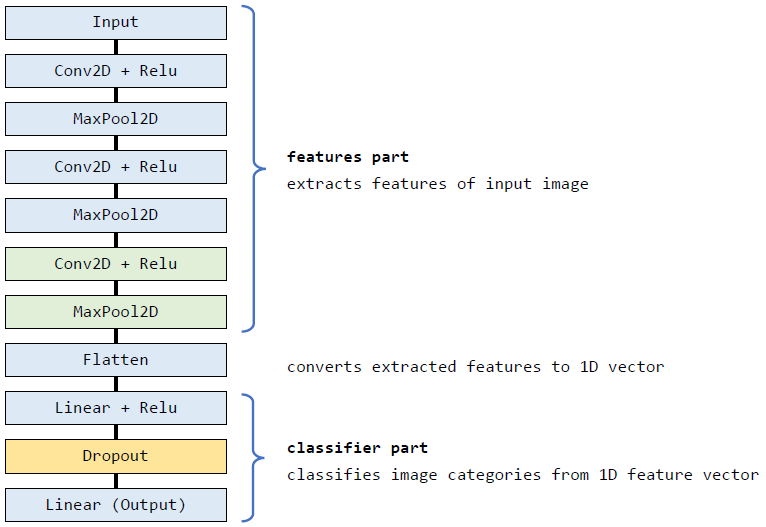

In [ ]:
import torch.nn as nn

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256*4*4, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),    # dropout layer
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)  
        return x
    
model = Model().to(device)
print(model)

### Dropout Layer

The dropout layer makes some of the neurons from previous layer to be 0 randomly with the probability of `p` during training. Since less information will propagete through the dropout layer, the model will be trained under more difficult situation. This will make the model more rubust.

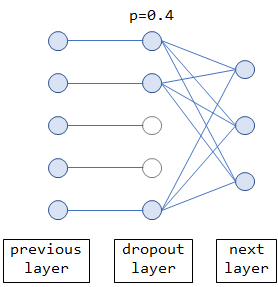

The dropout layer can be implemented with `nn.Dropout()`. The parameter `p` indicates the probabitlty of neurons to be 0 with a Bernoulli distribution. Also non-zero nodes will be scaled by a factor of 1/(1-p).

`nn.Dropout()` https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

In [ ]:
x = torch.ones(5)
y = nn.Dropout(p=0.4)(x)
print("input", x)
print("output", y)

### torchinfo
Let's see the model archtecture.

In [ ]:
! pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

## Training

### Loss Function

We use the cross-entropy loss as the loss function since this is a classification task.

In [22]:
loss_func = nn.CrossEntropyLoss()

### Optimizer

We use the Adam optimizer.

In [23]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1E-3)

### L1/L2 Regularization

L1 and L2 regularizations are implemented by adding a parameter norm penalty $\Omega$ to the loss value $\mathrm{loss}_0$ that is determined by the loss function such as `nn.CrossEntropyLoss()` as shown below.

$\mathrm{loss} = \mathrm{loss}_0 + \alpha\Omega$

where $\alpha$ is the relative contribution factor of $\Omega$.

#### L2 Norm Penalty
L2 norm penalty $\Omega_{L2}$ is adding-up by cumulating the squared value of all weights in the model as shown below.

$\displaystyle \Omega_{L2}=\sum_i w_i^2$

In [ ]:
def get_l2_norm(model=model):
    l2_norm = 0
    for p in model.parameters():
        l2_norm += p.pow(2).sum()
    return l2_norm

print("L2 Norm Penalty:", get_l2_norm(model).item())

#### L1 Regularization
L1 norm penalty $\Omega_{L1}$ is calculated by cumulating the absolute value of all weights in the model as shown below.

$\displaystyle \Omega_{L1}=\sum_{i} |w_i|$

In [ ]:
def get_l1_norm(model=model):
    l1_norm = 0
    for p in model.parameters():
        l1_norm += abs(p.sum())
    return l1_norm

print("L1 Norm Penalty:", get_l1_norm(model).item())

### Save Model Parameters

It is also a good idea to save the model parameters during the training so that we can load it later. We can do this with the code below.

In [27]:
model_path = "my_model.pth"
torch.save(model.state_dict(), model_path)

### Training Loop

Now we can train the model.

This time we save the model parameters after each epoch if the test accuracy is better than before. Then later we can load the best model.







In [35]:
model = Model().to(device)                             # load model to GPU
loss_func = nn.CrossEntropyLoss()                      # set loss function
optimizer = optim.Adam(model.parameters(), lr=1E-3)    # set optimizer
epochs = 20

best_model_path = 'best_model.pth'
best_accuracy = 0.0

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(epochs):
    print("-----------------------------")
    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    test_correct_count = 0
    test_accuracy = 0
    test_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:      # take mini batch data from train_loader
        
        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU
    
        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss

        #--- L1/L2 regularizaiton ---#
        alpha = 0.001
        loss = loss + alpha * get_l2_norm(model)    # add L2 penalty
        # loss = loss + alpha * get_l1_norm(model)  # add L1 penalty
        #----------------------------#

        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        pbar = tqdm(test_loader)
        pbar.set_description("Test") 

        for x_batch, y_batch in pbar:   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            test_loss += loss.item()                                # add up loss value

            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

            pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #------------------------#

    train_accuracy = train_correct_count.item()/len(train_dataset)   # determine accuracy for training data
    test_accuracy = test_correct_count.item()/len(test_dataset)      # determine accuracy for test data
    train_loss = train_loss/len(train_loader)                 # determine loss for training data
    test_loss = test_loss/len(test_loader)                    # determine loss for test data 

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Test: Accuracy={test_accuracy:.3f} Loss={test_loss:.3f}")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    # save the model if test accuracy is better than before
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), best_model_path)
        print(f"Test accuracy improved from {best_accuracy:.3f} to {test_accuracy:.3f}")
        print(f"Model saved at {best_model_path}")
        best_accuracy = test_accuracy

-----------------------------
Epoch 1/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.457 Loss=1.618, Test: Accuracy=0.569 Loss=1.186
Test accuracy improved from 0.000 to 0.569
Model saved at best_model.pth
-----------------------------
Epoch 2/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.593 Loss=1.343, Test: Accuracy=0.654 Loss=0.971
Test accuracy improved from 0.569 to 0.654
Model saved at best_model.pth
-----------------------------
Epoch 3/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.651 Loss=1.227, Test: Accuracy=0.701 Loss=0.858
Test accuracy improved from 0.654 to 0.701
Model saved at best_model.pth
-----------------------------
Epoch 4/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.676 Loss=1.169, Test: Accuracy=0.723 Loss=0.802
Test accuracy improved from 0.701 to 0.723
Model saved at best_model.pth
-----------------------------
Epoch 5/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.695 Loss=1.135, Test: Accuracy=0.729 Loss=0.801
Test accuracy improved from 0.723 to 0.729
Model saved at best_model.pth
-----------------------------
Epoch 6/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.708 Loss=1.107, Test: Accuracy=0.751 Loss=0.735
Test accuracy improved from 0.729 to 0.751
Model saved at best_model.pth
-----------------------------
Epoch 7/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.717 Loss=1.083, Test: Accuracy=0.740 Loss=0.756
-----------------------------
Epoch 8/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.724 Loss=1.074, Test: Accuracy=0.754 Loss=0.711
Test accuracy improved from 0.751 to 0.754
Model saved at best_model.pth
-----------------------------
Epoch 9/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.732 Loss=1.056, Test: Accuracy=0.760 Loss=0.693
Test accuracy improved from 0.754 to 0.760
Model saved at best_model.pth
-----------------------------
Epoch 10/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.736 Loss=1.043, Test: Accuracy=0.757 Loss=0.723
-----------------------------
Epoch 11/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.741 Loss=1.033, Test: Accuracy=0.758 Loss=0.695
-----------------------------
Epoch 12/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.744 Loss=1.030, Test: Accuracy=0.774 Loss=0.652
Test accuracy improved from 0.760 to 0.774
Model saved at best_model.pth
-----------------------------
Epoch 13/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.747 Loss=1.012, Test: Accuracy=0.769 Loss=0.676
-----------------------------
Epoch 14/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.752 Loss=1.010, Test: Accuracy=0.770 Loss=0.648
-----------------------------
Epoch 15/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.753 Loss=1.005, Test: Accuracy=0.769 Loss=0.677
-----------------------------
Epoch 16/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.755 Loss=0.995, Test: Accuracy=0.779 Loss=0.646
Test accuracy improved from 0.774 to 0.779
Model saved at best_model.pth
-----------------------------
Epoch 17/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.759 Loss=0.991, Test: Accuracy=0.776 Loss=0.649
-----------------------------
Epoch 18/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.757 Loss=0.987, Test: Accuracy=0.780 Loss=0.631
Test accuracy improved from 0.779 to 0.780
Model saved at best_model.pth
-----------------------------
Epoch 19/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.763 Loss=0.986, Test: Accuracy=0.770 Loss=0.664
-----------------------------
Epoch 20/20


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.764 Loss=0.984, Test: Accuracy=0.758 Loss=0.697


### Learning Curves

Let's visualize the accuracy and the loss curves for train and test data.

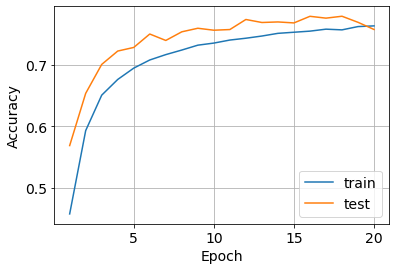

In [36]:
plt.rcParams["font.size"]=14
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, test_accuracy_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

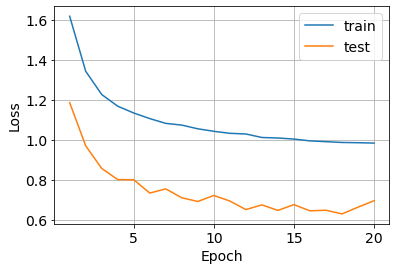

In [37]:
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, test_loss_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

As you see above, the test accuracy keeps increasing at least up to 10 epochs and is still higher than the train accuracy. Similarly the test loss keeps decreasing up to at least 10 epochs and still lower than the test loss. This is a sign of that the model is not overfitted yet. Therefore we can continue training the model further or we can use a larger model.

## Evaluation

### Load the Best Model

Now we can load the best model. What we saved in `best_model.pth` is only the model parameters. So first we need to load an initialized (not trained) model and then load the trained model parameters in there.

In [38]:
model = Model().to(device)                           # load an initialized model
model.load_state_dict(torch.load(best_model_path))   # load model parameters to the initialized model

<All keys matched successfully>

### Test Accuracy

We should check accuracy of the model for all of the test data.

In [39]:
test_accuracy = 0

y_test_all = np.array([])
p_label_all = np.array([])

with torch.no_grad():    # disable autograd
    model.eval()         # set model to evaluation mode
    
    for x_batch, y_batch in test_loader:    # take mini batch data from train_loader
        x_batch = x_batch.to(device)        # transfer x_batch to gpu
        y_batch = y_batch.to(device)        # transfer y_batch to gpu
        p_batch = model(x_batch)            # do prediction

        p_batch_label = torch.argmax(p_batch, dim=1)       # convert p_batch vector to p_batch_label
        test_accuracy += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        y_test_all = np.append(y_test_all, y_batch.to("cpu").numpy())          # append y_batch in y_test_all
        p_label_all = np.append(p_label_all, p_batch_label.to("cpu").numpy())  # append p_batch_label in p_label_all

test_accuracy = test_accuracy/len(test_dataset)      # determine accuracy for test data
print(f"Test Accuracy = {test_accuracy:.3f}")

Test Accuracy = 0.780


### Confusion Matrix

Then let's check the confusion matrix.

Text(0.5, 1.0, 'confusion matrix')

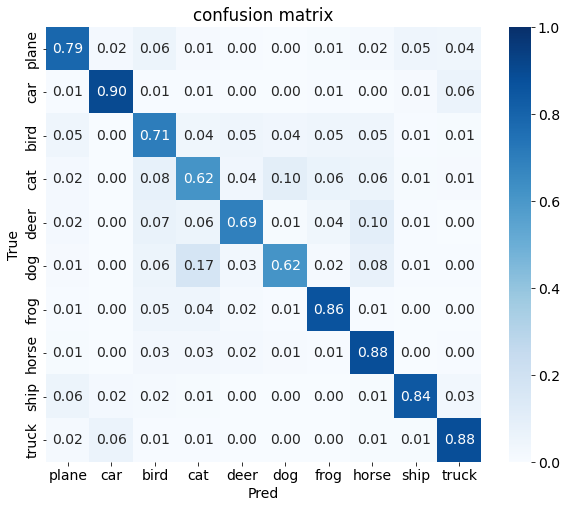

In [40]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test_all, p_label_all)

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.figure(figsize=(10,8))
labels = classnames.values()

sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=classnames.values(), yticklabels=classnames.values(), square=True)

plt.ylabel("True")
plt.xlabel("Pred")
plt.title("confusion matrix")

### Predictions for Test Data

Let's see predictions for some test data.

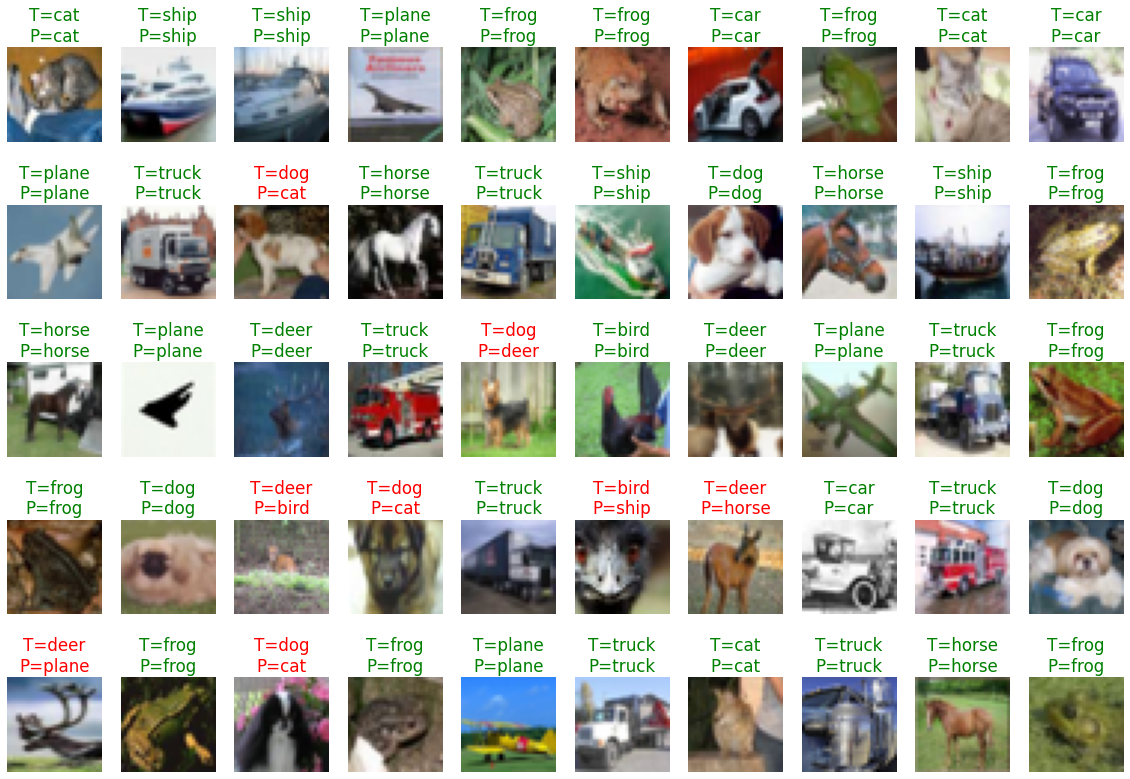

In [41]:
plt.figure(figsize=(20, 14))

for i in range(50):
    image, _ = test_dataset[i]
    image = np.transpose(image, (1,2,0))

    image[:, :, 0] = image[:, :, 0]*stds[0]+means[0]
    image[:, :, 1] = image[:, :, 1]*stds[1]+means[1]
    image[:, :, 2] = image[:, :, 2]*stds[2]+means[2]

    plt.subplot(5, 10, i+1)
    plt.imshow(image)

    true_class = classnames[y_test_all[i]]
    pred_class = classnames[p_label_all[i]]
    if true_class == pred_class:
        color = "green"
    else:
        color = "red"
    plt.title(f"T={true_class}\nP={pred_class}", color=color)
    plt.axis("off")

## Conclusion
That's it for this week. Now you can try to improve the test accuracy by changing data augmentation methods, model architecture, training epochs and so on...